In [1]:
# importing libraries needed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import when, min, max, col, round, lower, trim, countDistinct, count, sum, month, hour
from pyspark.sql import Window

from pyspark.sql.functions import sum as spark_sum, col, when

## Starting PySpark session

In [2]:
# sets logging level for py4j (used by pyspark to communicate with JVM, Java Virtual Machine)

import logging
logging.getLogger("py4j").setLevel(logging.INFO)

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("EDA") \
        .config("spark.ui.showConsoleProgress", "false") \
        .config("spark.local.dir", "C:/temp/spark") \
        .getOrCreate()

spark

In [4]:
# Load cleaned datasets and functions created

# Add src to the Python path if needed
import sys
sys.path.append("../raw_functions")

from raw_functions.delivery_time import time_taken_to_deliver, flag_delivery_speed_relative
from raw_functions.distance import add_order_delivery_distance
from raw_functions.installment_flagging import add_high_installment_flag
from raw_functions.product_category import get_category_in_english, group_categories_by_sales_with_ohe
from raw_functions.repeat_buyers import finding_repeat_buyers
from raw_functions.final_dataset import build_final_dataset

df_orders           = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_orders.csv", header=True)
df_customers        = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_customers.csv", header=True)
df_order_items      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_items.csv", header=True)
df_products         = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_products.csv", header=True)
df_order_payments   = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_payments.csv", header=True)
df_sellers          = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_seller.csv", header=True)
df_order_reviews        = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_reviews.csv", header=True)
df_geolocation      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_geolocation.csv", header=True)
df_product_category = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/product_category_name_translation.csv", header=True)

print("All done!")

All done!


## Introduction to EDA

Objectives for this EDA:

1. Understand and doing basic cleaning on the datasets given
- Find missing values, duplicates or data that have inconsistent formats
- Identify and handle outliers
- Checking for invalid timestamps (e.g. delivery occurs before purchase date)

2. Distribution of data and relationship
- Most commmon product categories, payment methods, purchase hour

3. Customer Behaviour Analysis
- How many repeat buyers exist?
- Average time between orders for repeat buyers
- Preference of repeat buyers (What are they repurchasing)

4. Payment analysis
- Does customers who make paymetns with vouchers behave diffferntly?
- Is there a relationship between high installments (high installment value/high amount of installments made) and low repurchases?

5. Delivery pattern
- How long does delivery take?
- Will long delivery duration cause bad reviews or lower chances of repeat orders?
- Distance between customer and seller

6. Review score
- Are review scores linked to repeat purchases?

7. Product category
- Which product categories are the most popular?
- Group categories which are not popular under 'others'
- Do one-hot encoding on product categories

Final EDA Goal:

To prepare, clean, insightful dataset with features that will be helpful in helping the model to find repeat buyers.

### 1. Understanding and doing basic cleaning on datasets

In [ ]:
# christel's code will be in/under this markdown cell

# Find missing values, duplicates or data that have inconsistent formats
# Identify and handle outliers
# Checking for invalid timestamps (e.g. delivery occurs before purchase date)

### 2. Distribution of data and relationship

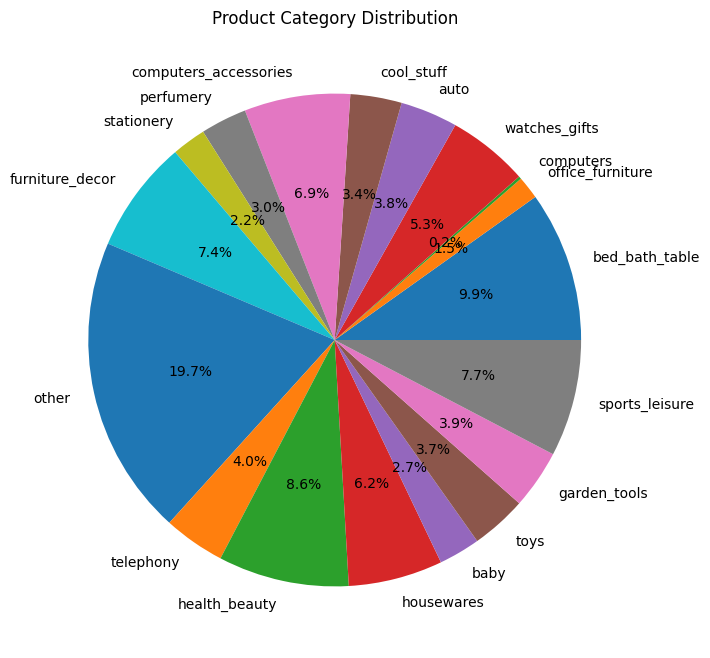

In [36]:
# most common roducts
df_category_price = get_category_in_english(df_order_items, df_products, df_product_category)
df_ohe = group_categories_by_sales_with_ohe(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8)
df_grouped_counts_pd = df_ohe.groupBy("category_grouped").count().toPandas()

# Now, plot the Pandas DataFrame which has the 'count' column
df_grouped_counts_pd.set_index("category_grouped").plot.pie(y="count", autopct='%1.1f%%', figsize=(25, 8)).legend().remove()
plt.ylabel("")
plt.title("Product Category Distribution")
plt.show()

### 3. Customer Behaviour Analysis

#### Preference of repeat buyers 

In [ ]:
from pyspark.sql.functions import col, countDistinct, count

# Step 1: Identify repeat buyers
repeat_buyers = finding_repeat_buyers(df_orders, df_customers, df_order_items) \
    .filter(col("is_repeat_buyer") == 1)

# Step 2: Join to get customer_id and order_id (since repeat_buyers has customer_unique_id only)
repeat_orders = df_orders.join(
    df_customers.select("customer_id", "customer_unique_id"),
    on="customer_id",
    how="left"
).join(
    repeat_buyers.select("customer_unique_id"),
    on="customer_unique_id",
    how="inner"
)

# Step 3: Get product category per repeat order
repeat_items = repeat_orders.select("customer_id", "order_id") \
    .join(df_order_items, on="order_id", how="inner") \
    .join(df_products.select("product_id", "product_category_name"), on="product_id", how="left")

# Step 4: Count how many *distinct orders* each repeat buyer purchased a given category in
repeat_category_counts = repeat_items.groupBy("customer_id", "product_category_name") \
    .agg(countDistinct("order_id").alias("distinct_order_count")) \
    .filter("distinct_order_count > 1")  # They purchased same category in 2+ orders

# Step 5: Group by category to see which categories were repurchased the most
repurchased_categories = repeat_category_counts.groupBy("product_category_name") \
    .agg(count("customer_id").alias("num_repeat_buyers")) \
    .orderBy(col("num_repeat_buyers").desc())

repurchased_categories.show(10)


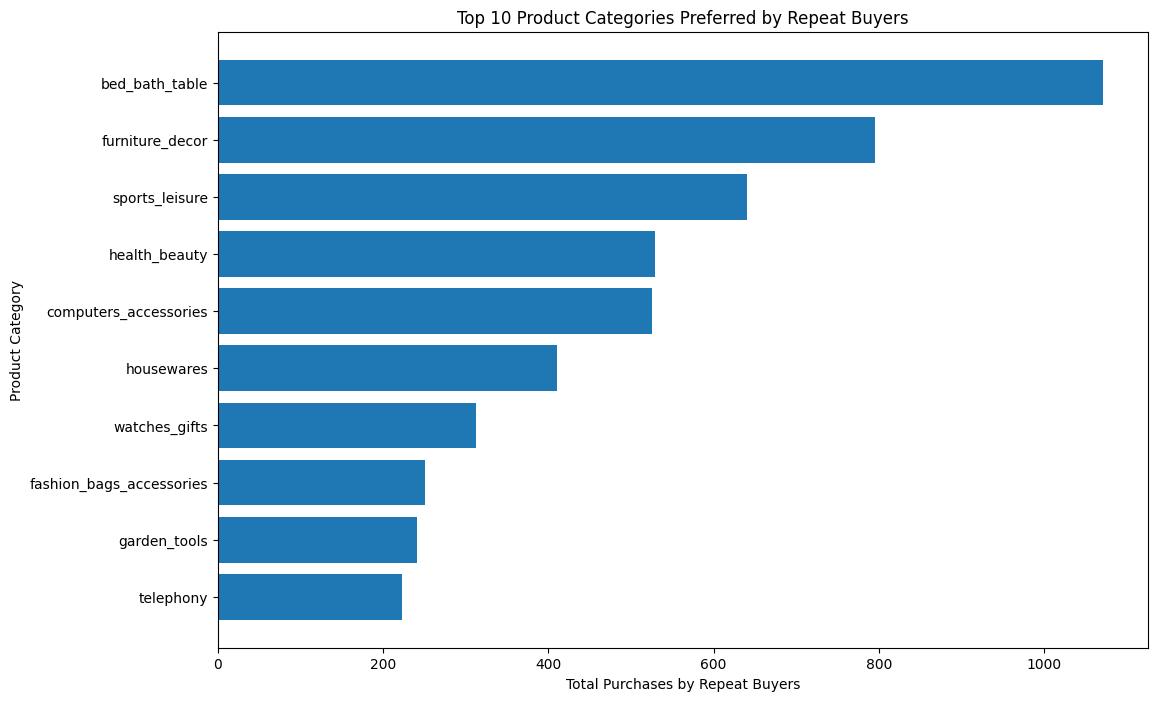

In [ ]:
from pyspark.sql.functions import col

repeat_category_counts = repeat_items.groupBy("customer_id", "product_category_name") \
    .agg(count("order_id").alias("num_purchases")) \
    .orderBy("customer_id", "num_purchases", ascending=False)

category_popularity = repeat_category_counts.groupBy("product_category_name") \
    .agg({"num_purchases": "sum"}) \
    .withColumnRenamed("sum(num_purchases)", "total_purchases") \
    .orderBy("total_purchases", ascending=False)

category_popularity_pd = category_popularity.toPandas()

# Join to get English category names
category_with_english = category_popularity.join(
    df_product_category.select("product_category_name", "product_category_name_english"),
    on="product_category_name",
    how="left"
)

# Select needed columns and drop null English names if any
category_with_english = category_with_english.filter(col("product_category_name_english").isNotNull())

# Order by total purchases and take top 10
top_10_categories = category_with_english.orderBy(col("total_purchases").desc()).limit(10)

# Convert to Pandas for plotting
top_10_pd = top_10_categories.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(top_10_pd['product_category_name_english'], top_10_pd['total_purchases'])
plt.xlabel("Total Purchases by Repeat Buyers")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories Preferred by Repeat Buyers")
plt.gca().invert_yaxis()  # Highest on top
plt.show()


#### Time between orders for repeat buyers

In [55]:
from pyspark.sql.functions import col, lag, datediff, when
from pyspark.sql.window import Window

def add_repeat_order_gaps(df_orders, df_customers, customer_order_counts):
    """
    For repeat buyers, calculate time between current order and previous order.
    Sets null gaps to 1 (for models that only accept integers).

    Parameters:
        df_orders: orders DataFrame with order_id, customer_id, order_purchase_timestamp
        df_customers: customers DataFrame with customer_id and customer_unique_id
        customer_order_counts: output from finding_repeat_buyers()

    Returns:
        DataFrame with:
        - customer_unique_id
        - order_id
        - order_purchase_timestamp
        - prev_order_date
        - days_since_last_order (int, with null → 1)
        - is_first_order (1 if null before, else 0)
    """

    # Step 1: Join orders with customer_unique_id
    df_joined = df_orders.join(df_customers, on="customer_id", how="inner")

    # Step 2: Add repeat buyer flag
    df_repeat_flag = df_joined.join(
        customer_order_counts.select("customer_unique_id", "is_repeat_buyer"),
        on="customer_unique_id", how="left"
    )

    # Step 3: Filter to repeat buyers
    df_repeat_only = df_repeat_flag.filter(col("is_repeat_buyer") == 1)

    # Step 4: Define window for previous order
    window_spec = Window.partitionBy("customer_unique_id").orderBy("order_purchase_timestamp")

    # Step 5: Add previous date and calculate gap
    df_with_gaps = df_repeat_only.withColumn(
        "prev_order_date", lag("order_purchase_timestamp").over(window_spec)
    ).withColumn(
        "raw_days_since_last_order",
        datediff("order_purchase_timestamp", "prev_order_date")
    )

    # Step 6: Handle nulls → 1 and add is_first_order flag
    df_with_flags = df_with_gaps.withColumn(
        "days_since_last_order",
        when(col("raw_days_since_last_order").isNull(), -1).otherwise(col("raw_days_since_last_order"))
    )
    return df_with_flags

In [68]:
customer_order_counts = finding_repeat_buyers(df_orders, df_customers, df_order_items)
df_with_flags = add_repeat_order_gaps(df_orders, df_customers, customer_order_counts).select(
        "customer_unique_id",
        "order_id",
        "order_purchase_timestamp",
        "prev_order_date",
        "days_since_last_order",
    )
df_with_flags.show(5)

+--------------------+--------------------+------------------------+-------------------+---------------------+
|  customer_unique_id|            order_id|order_purchase_timestamp|    prev_order_date|days_since_last_order|
+--------------------+--------------------+------------------------+-------------------+---------------------+
|004288347e5e88a27...|a61d617fbe5bd006e...|     2017-07-27 14:13:03|               null|                   -1|
|004288347e5e88a27...|08204559bebd39e09...|     2018-01-14 07:36:54|2017-07-27 14:13:03|                  171|
|00a39521eb40f7012...|7d32c87acba91ed87...|     2018-05-23 20:14:21|               null|                   -1|
|00a39521eb40f7012...|cea3e6c11eb60acb9...|     2018-06-03 10:12:57|2018-05-23 20:14:21|                   11|
|012452d40dafae4df...|ce2b4f2836d78829e...|     2017-06-18 22:46:42|               null|                   -1|
+--------------------+--------------------+------------------------+-------------------+---------------------+
o

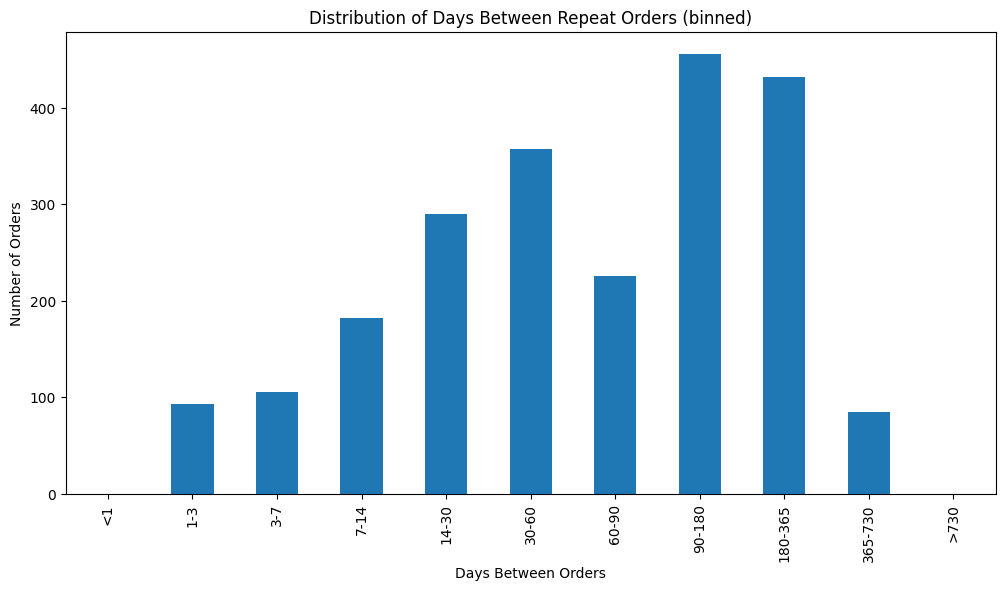

In [69]:
bins = [0, 1, 3, 7, 14, 30, 60, 90, 180, 365, 730, 10000]
labels = ['<1', '1-3', '3-7', '7-14', '14-30', '30-60', '60-90', '90-180', '180-365', '365-730', '>730']

non_first_orders = df_with_flags.filter("days_since_last_order > 0").select("days_since_last_order").toPandas()

non_first_orders['bins'] = pd.cut(non_first_orders['days_since_last_order'], bins=bins, labels=labels, right=False)

binned_counts = non_first_orders['bins'].value_counts().sort_index()

plt.figure(figsize=(12,6))
binned_counts.plot(kind='bar')
plt.xlabel('Days Between Orders')
plt.ylabel('Number of Orders')
plt.title('Distribution of Days Between Repeat Orders (binned)')
plt.show()


#### Orders purchased by hour of the day

root
 |-- order_id: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- time_of_purchase: integer (nullable = true)
 |-- month_of_purchase: integer (nullable = true)
 |-- delivered_in_days: double (nullable = true)



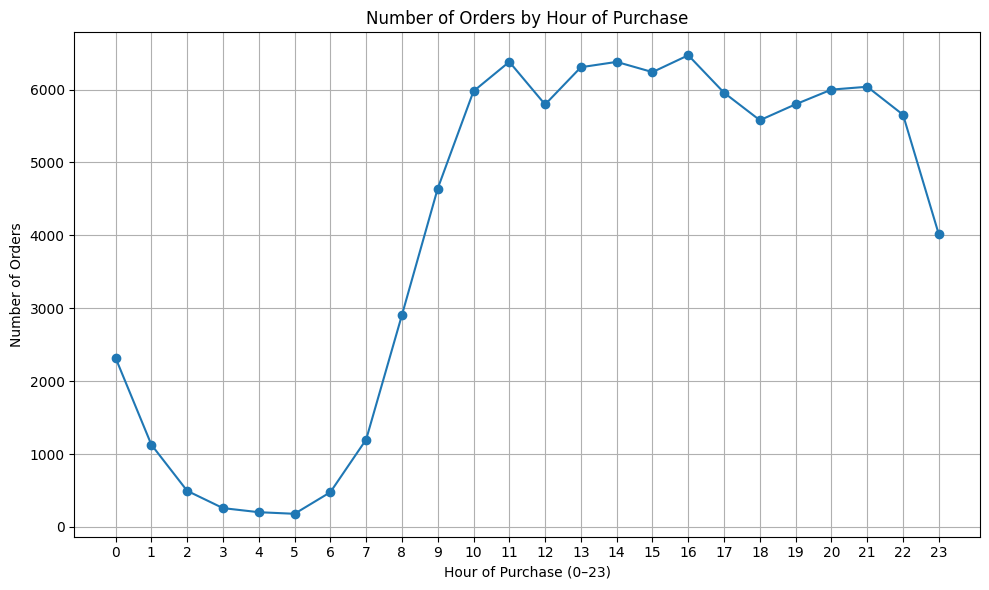

In [33]:
df_time = time_taken_to_deliver(df_orders)

df_time.printSchema()

from pyspark.sql.functions import to_timestamp, hour

df_time_clean = df_time \
    .withColumn("order_purchase_timestamp", to_timestamp("order_purchase_timestamp")) \
    .withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date")) \
    .withColumn("time_of_purchase", hour("order_purchase_timestamp")) \
    .select("time_of_purchase") \
    .filter("time_of_purchase IS NOT NULL")

delivery_pd = df_time_clean.toPandas()

orders_by_hour = delivery_pd.groupby('time_of_purchase').size().reset_index(name='num_orders')

plt.figure(figsize=(10,6))
plt.plot(orders_by_hour['time_of_purchase'], orders_by_hour['num_orders'], marker='o', linestyle='-')
plt.title("Number of Orders by Hour of Purchase")
plt.xlabel("Hour of Purchase (0–23)")
plt.ylabel("Number of Orders")
plt.xticks(range(0, 24))  # make sure all 24 hours show
plt.grid(True)
plt.tight_layout()

### 4. Payment analysis

#### No. of repeat buyers who used vouchers

In [34]:
repeat_buyers = finding_repeat_buyers(df_orders, df_customers, df_order_items)

voucher_users = df_order_payments.filter(col("payment_type") == "voucher") \
    .select("order_id").distinct()

voucher_customers = df_orders.join(voucher_users, on="order_id") \
    .select("customer_id").distinct()

voucher_behavior = df_customers.join(voucher_customers, on="customer_id", how="inner") \
    .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id", how="left")

voucher_behavior.groupBy("is_repeat_buyer").count().show()


+---------------+-----+
|is_repeat_buyer|count|
+---------------+-----+
|              1|  308|
|              0| 3369|
+---------------+-----+



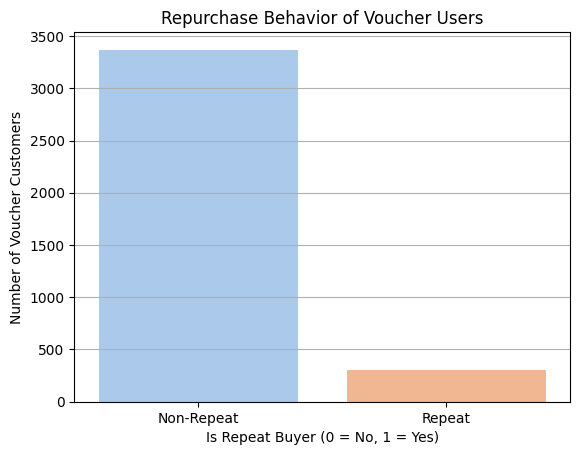

In [35]:
voucher_behavior_pd = voucher_behavior.groupBy("is_repeat_buyer").count().toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Replace nulls in case some customers weren't matched in repeat_buyers
voucher_behavior_pd['is_repeat_buyer'] = voucher_behavior_pd['is_repeat_buyer'].fillna(0).astype(int)
voucher_behavior_pd = voucher_behavior_pd.sort_values("is_repeat_buyer")

sns.barplot(data=voucher_behavior_pd, x="is_repeat_buyer", y="count", palette="pastel")
plt.title("Repurchase Behavior of Voucher Users")
plt.xlabel("Is Repeat Buyer (0 = No, 1 = Yes)")
plt.ylabel("Number of Voucher Customers")
plt.xticks([0, 1], ["Non-Repeat", "Repeat"])
plt.grid(True, axis='y')
plt.show()

#### Relationship between high installments and low repurchases

In [ ]:
df_installments = add_high_installment_flag(df_order_payments)

payment_behavior = df_installments.join(df_orders, on="order_id") \
    .join(df_customers.select("customer_id", "customer_unique_id"), on="customer_id") \
    .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id")

payment_behavior.groupBy("high_installment_flag", "is_repeat_buyer").count().show()

from pyspark.sql.functions import count, sum

payment_behavior.groupBy("high_installment_flag").agg(
    count("*").alias("total"),
    sum("is_repeat_buyer").alias("num_repeat_buyers")
).withColumn("repurchase_rate", col("num_repeat_buyers") / col("total")).show()


+---------------------+---------------+-----+
|high_installment_flag|is_repeat_buyer|count|
+---------------------+---------------+-----+
|                    1|              0|63171|
|                    1|              1| 4454|
|                    0|              0|31232|
|                    0|              1| 1812|
+---------------------+---------------+-----+

+---------------------+-----+-----------------+-------------------+
|high_installment_flag|total|num_repeat_buyers|    repurchase_rate|
+---------------------+-----+-----------------+-------------------+
|                    1|67625|             4454|0.06586321626617375|
|                    0|33044|             1812|0.05483597627405883|
+---------------------+-----+-----------------+-------------------+



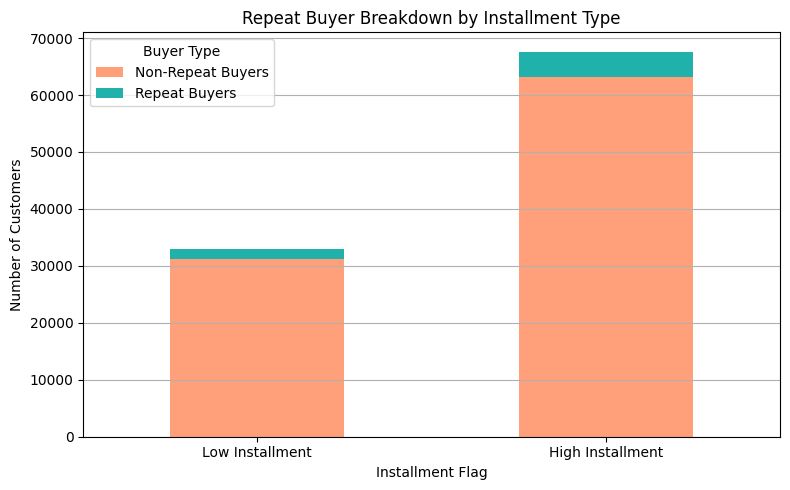

In [31]:
installment_behavior_pd = payment_behavior.groupBy("high_installment_flag", "is_repeat_buyer").count().toPandas()

installment_pivot = installment_behavior_pd.pivot(
    index="high_installment_flag", columns="is_repeat_buyer", values="count"
).fillna(0)

installment_pivot.columns = ['Non-Repeat Buyers', 'Repeat Buyers']
installment_pivot.index = ['Low Installment', 'High Installment']

installment_pivot.plot(kind="bar", stacked=True, color=["#FFA07A", "#20B2AA"], figsize=(8, 5))
plt.title("Repeat Buyer Breakdown by Installment Type")
plt.ylabel("Number of Customers")
plt.xlabel("Installment Flag")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title="Buyer Type")
plt.tight_layout()
plt.show()


### 5. Delivery pattern

In [ ]:
# How long does delivery take?
# Will long delivery duration cause bad reviews or lower chances of repeat orders?
# Distance between customer and seller

### 6. Review score

#### Are review scores linked to repeat purchases?

In [71]:
from pyspark.sql.functions import col, avg

# Join reviews with orders and customers (assuming you have df_reviews with order_id, review_score)
df_reviews_with_customers = df_order_reviews.join(df_orders.select("order_id", "customer_id"), on="order_id") \
                                     .join(df_customers.select("customer_id", "customer_unique_id"), on="customer_id") \
                                     .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id")

# Calculate average review score per customer
avg_scores = df_reviews_with_customers.groupBy("customer_unique_id", "is_repeat_buyer") \
                                     .agg(avg("review_score").alias("avg_review_score"))

# Convert to pandas for plotting
avg_scores_pd = avg_scores.toPandas()


c:\Users\jiawe\OneDrive\Documents\GitHub\309Project\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


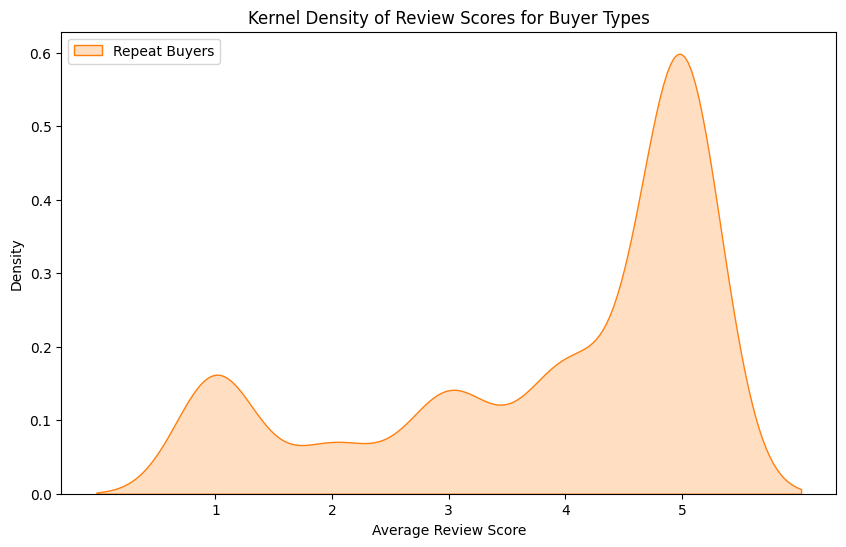

In [75]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=avg_scores_pd[avg_scores_pd['is_repeat_buyer'] == 0], x='avg_review_score', label='Non-Repeat Buyers', fill=True)
sns.kdeplot(data=avg_scores_pd[avg_scores_pd['is_repeat_buyer'] == 1], x='avg_review_score', label='Repeat Buyers', fill=True)
plt.xlabel('Average Review Score')
plt.xticks(range(1, 6))
plt.title('Kernel Density of Review Scores for Buyer Types')
plt.legend()
plt.show()


### 7. Product category

#### product categories are the most popular based on the amount of sales

In [77]:
from pyspark.sql.functions import round

def get_top_category_sales(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8):
    # Step 1: Calculate total sales per category
    sales_per_category = df_category_price.groupBy(category_col) \
        .agg(spark_sum(value_col).alias("total_sales"))

    # Step 2: Calculate total overall sales (scalar)
    total_sales = df_category_price.agg(spark_sum(value_col).alias("overall_total")).collect()[0]["overall_total"]

    # Step 3: Calculate percent and cumulative percent
    window_spec = Window.orderBy(col("total_sales").desc()).rowsBetween(Window.unboundedPreceding, 0)

    sales_enriched = sales_per_category \
        .withColumn("category_sales_percent", col("total_sales") / total_sales) \
        .withColumn("cumulative_pct", spark_sum("category_sales_percent").over(window_spec))

    # Step 4: Extract top categories within threshold
    top_categories = sales_enriched.filter(col("cumulative_pct") <= threshold) \
        .orderBy(col("total_sales").desc()) \
        .select(
            col(category_col),
            round(col("total_sales"), 2).alias("total_sales"),
            (col("category_sales_percent") * 100).alias("sales_percent"),
            (col("cumulative_pct") * 100).alias("cumulative_percent")
        )

    return top_categories

df_category_price = get_category_in_english(df_order_items, df_products, df_product_category)
top_cats_df = get_top_category_sales(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8)
top_cats_df.show(truncate=False)


+-----------------------------+-----------+------------------+------------------+
|product_category_name_english|total_sales|sales_percent     |cumulative_percent|
+-----------------------------+-----------+------------------+------------------+
|health_beauty                |1258681.34 |9.260699940209122 |9.260699940209122 |
|watches_gifts                |1205005.68 |8.86578331949174  |18.126483259700862|
|bed_bath_table               |1036039.18 |7.622618741833781 |25.74910200153464 |
|sports_leisure               |988048.97  |7.2695326025908145|33.01863460412545 |
|computers_accessories        |911954.32  |6.709669118235596 |39.72830372236105 |
|furniture_decor              |729762.49  |5.369199679650266 |45.09750340201131 |
|cool_stuff                   |635290.85  |4.67412819245435  |49.77163159446567 |
|housewares                   |632248.66  |4.651745395589282 |54.42337699005495 |
|auto                         |592720.11  |4.3609155969830775|58.784292587038024|
|garden_tools   

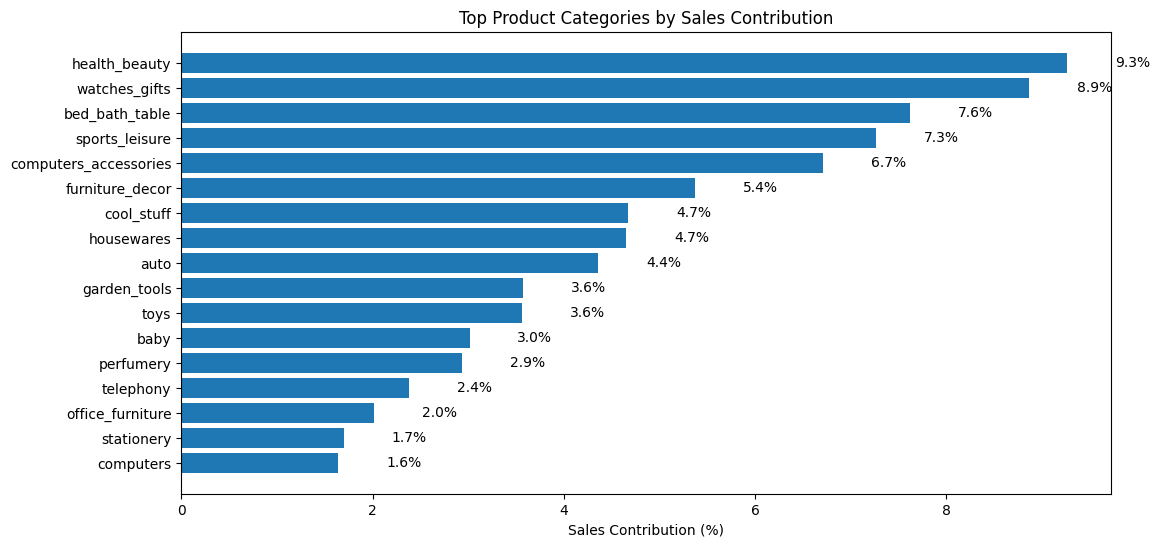

In [79]:
import matplotlib.pyplot as plt

top_cats_pd = top_cats_df.toPandas()

plt.figure(figsize=(12, 6))
bars = plt.barh(top_cats_pd['product_category_name_english'], top_cats_pd['sales_percent'])

plt.xlabel("Sales Contribution (%)")
plt.title("Top Product Categories by Sales Contribution")
plt.gca().invert_yaxis()  # Largest on top

# Add labels on the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center')

plt.show()


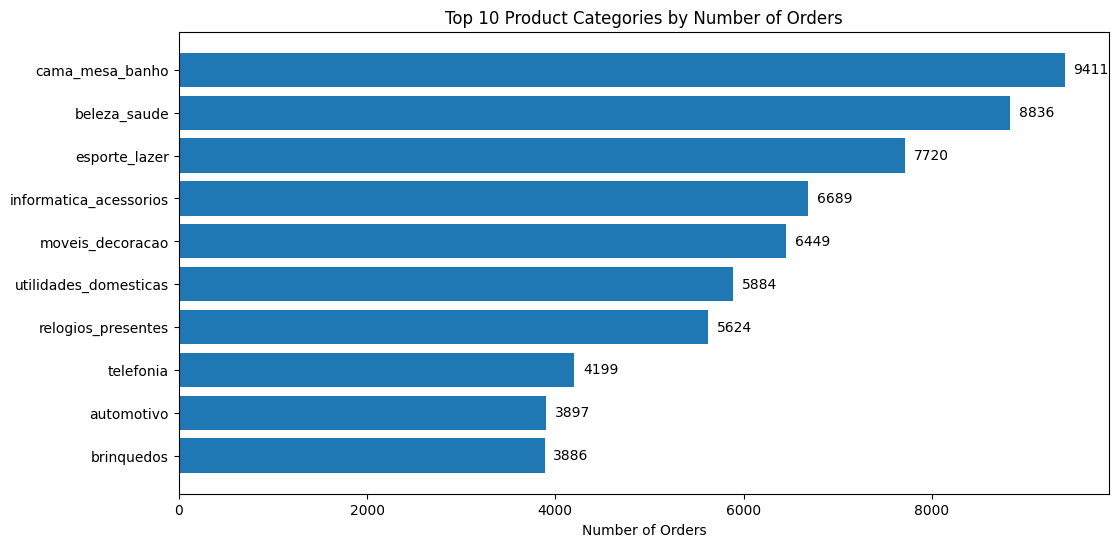

In [82]:
from pyspark.sql.functions import countDistinct

# Step 1: Get number of distinct orders per product category
category_order_counts = df_order_items.join(
    df_products.select("product_id", "product_category_name"),
    on="product_id",
    how="left"
).groupBy("product_category_name") \
 .agg(countDistinct("order_id").alias("num_orders")) \
 .orderBy("num_orders", ascending=False)

# Convert to Pandas for plotting
category_order_counts_pd = category_order_counts.toPandas()

# Optional: Take top 10 categories for clarity
top_categories_pd = category_order_counts_pd.head(10)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bars = plt.barh(top_categories_pd['product_category_name'], top_categories_pd['num_orders'])
plt.xlabel("Number of Orders")
plt.title("Top 10 Product Categories by Number of Orders")
plt.gca().invert_yaxis()  # largest on top

# Add labels to bars
import builtins  # import python built-in functions module

for bar in bars:
    width = bar.get_width()
    plt.text(width + builtins.max(top_categories_pd['num_orders']) * 0.01, 
             bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center')


plt.show()


## Final dataset

In [84]:
final_df = build_final_dataset(
    df_order_items, df_products, df_product_category, df_orders,
    df_customers, df_sellers, df_order_payments, df_geolocation, df_order_reviews
)

final_df.show()

+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|            order_id|  customer_unique_id|         customer_id|delivered_in_days|time_of_purchase|month_of_purchase|delivery_speed_flag|delivery_distance_in_km|installment_value|high_installment_flag|used_voucher|is_repeat_buyer|num_orders|total_purchase_value|category_grouped_ohe|          product_id|review_score|
+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|00042b26cf59d7ce6...|64b576fb70d441e8f...|58d

In [85]:
final_df.show()

+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|            order_id|  customer_unique_id|         customer_id|delivered_in_days|time_of_purchase|month_of_purchase|delivery_speed_flag|delivery_distance_in_km|installment_value|high_installment_flag|used_voucher|is_repeat_buyer|num_orders|total_purchase_value|category_grouped_ohe|          product_id|review_score|
+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|00042b26cf59d7ce6...|64b576fb70d441e8f...|58d

### Feature Correalation

In [86]:
features_to_keep = [
    "delivered_in_days", "time_of_purchase", "month_of_purchase", "delivery_speed_flag",
    "delivery_distance_in_km", "installment_value", "high_installment_flag", "used_voucher",
    "is_repeat_buyer", "num_orders", "total_purchase_value", "review_score"
]

# Convert one-hot encoded vector to individual columns if needed
from pyspark.ml.functions import vector_to_array

final_df_cleaned = final_df.select(
    *features_to_keep,
    vector_to_array("category_grouped_ohe").alias("category_ohe_array")
)

# Convert vector to separate columns
from pyspark.sql.functions import col

num_ohe_dims = final_df.select("category_grouped_ohe").first()["category_grouped_ohe"].size
ohe_columns = [col("category_ohe_array")[i].alias(f"category_{i}") for i in range(num_ohe_dims)]

final_df_flat = final_df_cleaned.select(*features_to_keep, *ohe_columns)


In [87]:
final_pd = final_df_flat.toPandas()

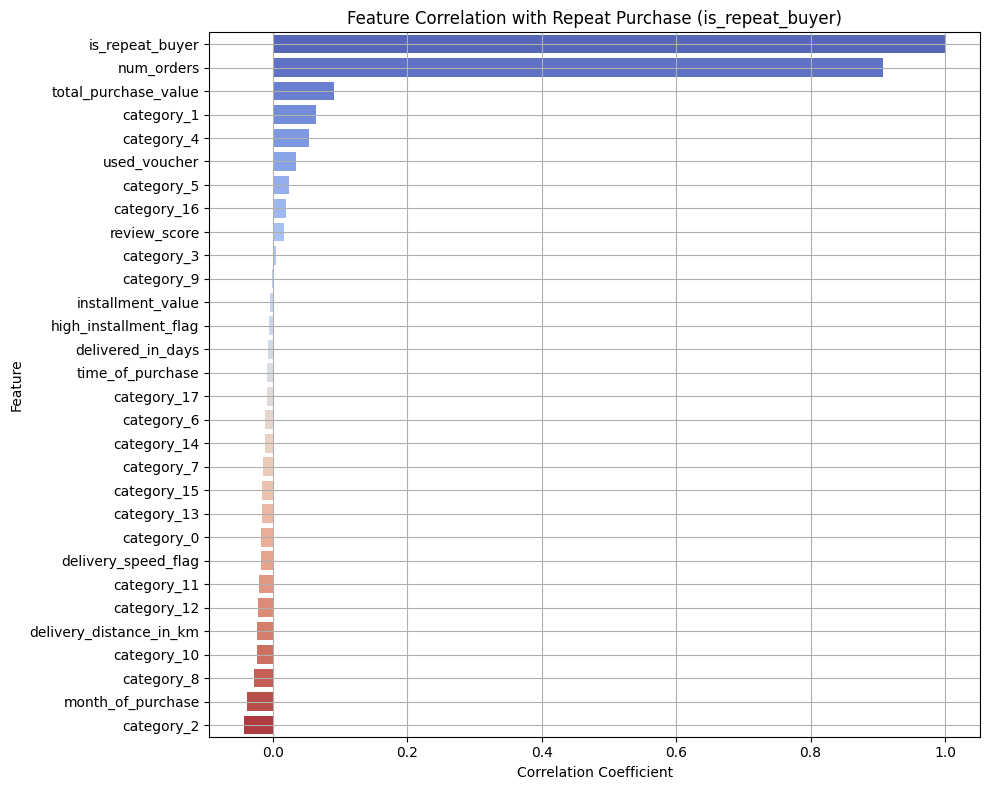

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = final_pd.corr(numeric_only=True)

# Focused heatmap: correlation with target
target_corr = corr_matrix["is_repeat_buyer"].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Feature Correlation with Repeat Purchase (is_repeat_buyer)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()


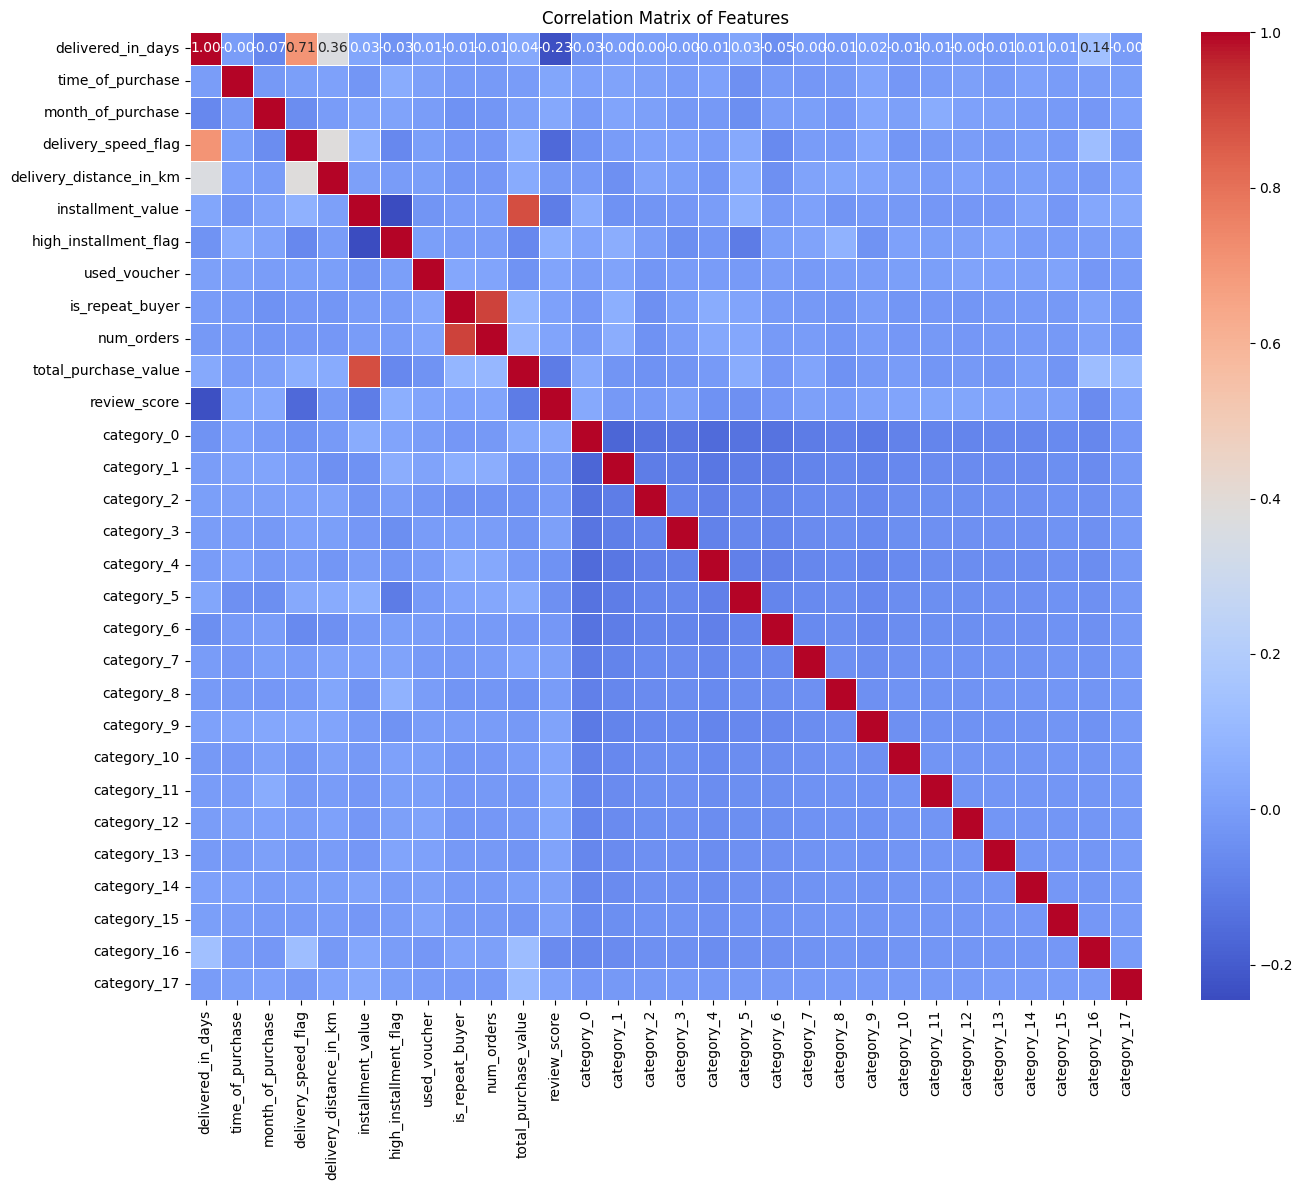

In [89]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

## LR

In [95]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.functions import vector_to_array

# === 1. Define your features ===
raw_feature_cols = [
    "delivered_in_days",
    "time_of_purchase",
    "month_of_purchase",
    "delivery_speed_flag",
    "delivery_distance_in_km",
    "installment_value",
    "high_installment_flag",
    "used_voucher",
    "num_orders",
    "total_purchase_value",
    "review_score"
]

# === 2. Explode OneHotEncoded category column (category_grouped_ohe) ===
df = final_df.withColumn("ohe_array", vector_to_array("category_grouped_ohe"))
num_dims = len(df.select("ohe_array").first()[0])

# Create individual category columns
for i in range(num_dims):
    df = df.withColumn(f"category_ohe_{i}", col("ohe_array")[i])

# Create full feature list (numeric + exploded OHE features)
ohe_feature_cols = [f"category_ohe_{i}" for i in range(num_dims)]
feature_cols = raw_feature_cols + ohe_feature_cols

# === 3. Cast all feature columns to double and fill nulls ===
for c in feature_cols:
    df = df.withColumn(c, col(c).cast("double"))

df = df.fillna(0, subset=feature_cols)

# === 4. Assemble features into a single vector ===
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", "is_repeat_buyer")

# === 5. Fit logistic regression model ===
lr = LogisticRegression(featuresCol="features", labelCol="is_repeat_buyer")
lr_model = lr.fit(assembled_df)

# === 6. Summary ===
training_summary = lr_model.summary
print("Accuracy:", training_summary.accuracy)
print("Area Under ROC:", training_summary.areaUnderROC)
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Accuracy: 1.0
Area Under ROC: 0.9999994027840805
Coefficients: [0.001490725937255467,-0.0014891495111402048,-0.012482389281153165,0.009297068471545747,-1.7525717728532046e-05,-0.00043740612440832874,-0.03931449352519794,0.17257572600357682,36.133619063294816,0.00037148108433288177,0.012285189218801753,-0.038435106314282985,0.1522345400673385,-0.10628728951411934,0.05027903868872832,0.15675889799146883,0.040295657178202215,-0.04269653364888824,-0.07819245606044149,-0.09164037313137793,0.04173385286186637,-0.12847320027111955,-0.09199158101658929,-0.1143789119822196,-0.061110248378340046,-0.054213173667400555,-0.06766891856394625,-0.009741457488927524,-0.5995857693827245]
Intercept: -54.79387961007609


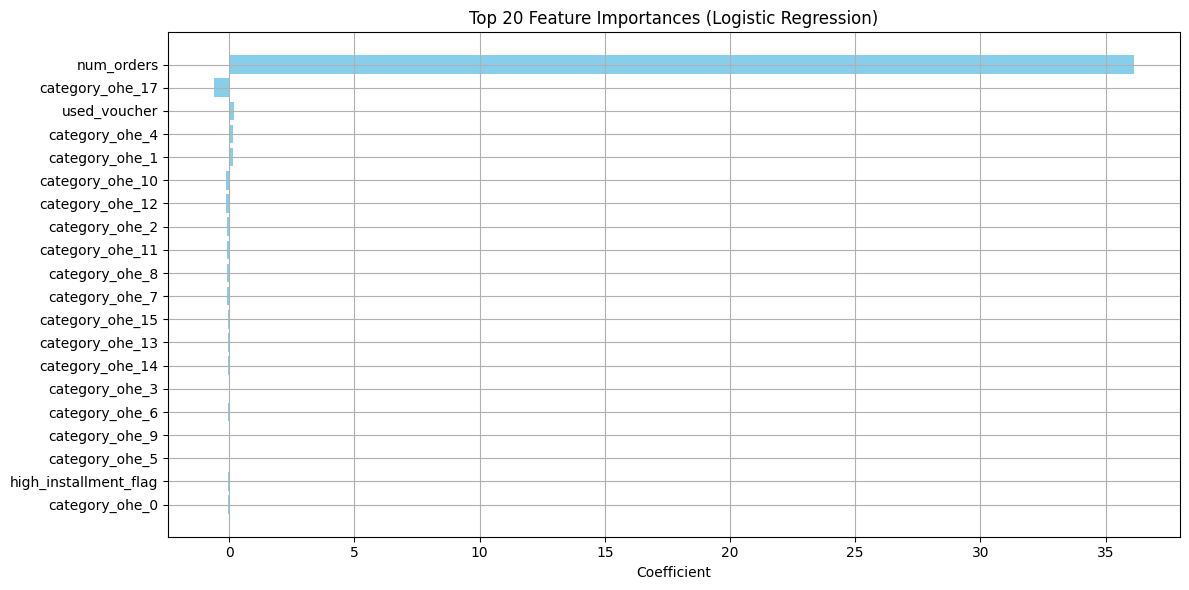

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combine raw feature names and one-hot encoded category names
all_features = raw_feature_cols + ohe_feature_cols

# Convert coefficients to NumPy array
coefficients = np.array(lr_model.coefficients.toArray())

# Create a DataFrame for plotting
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})

# Get top 20 features by absolute coefficient magnitude
top_coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_coef_df["feature"], top_coef_df["coefficient"], color='skyblue')
plt.xlabel("Coefficient")
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.gca().invert_yaxis()  # highest at top
plt.grid(True)
plt.tight_layout()
plt.show()


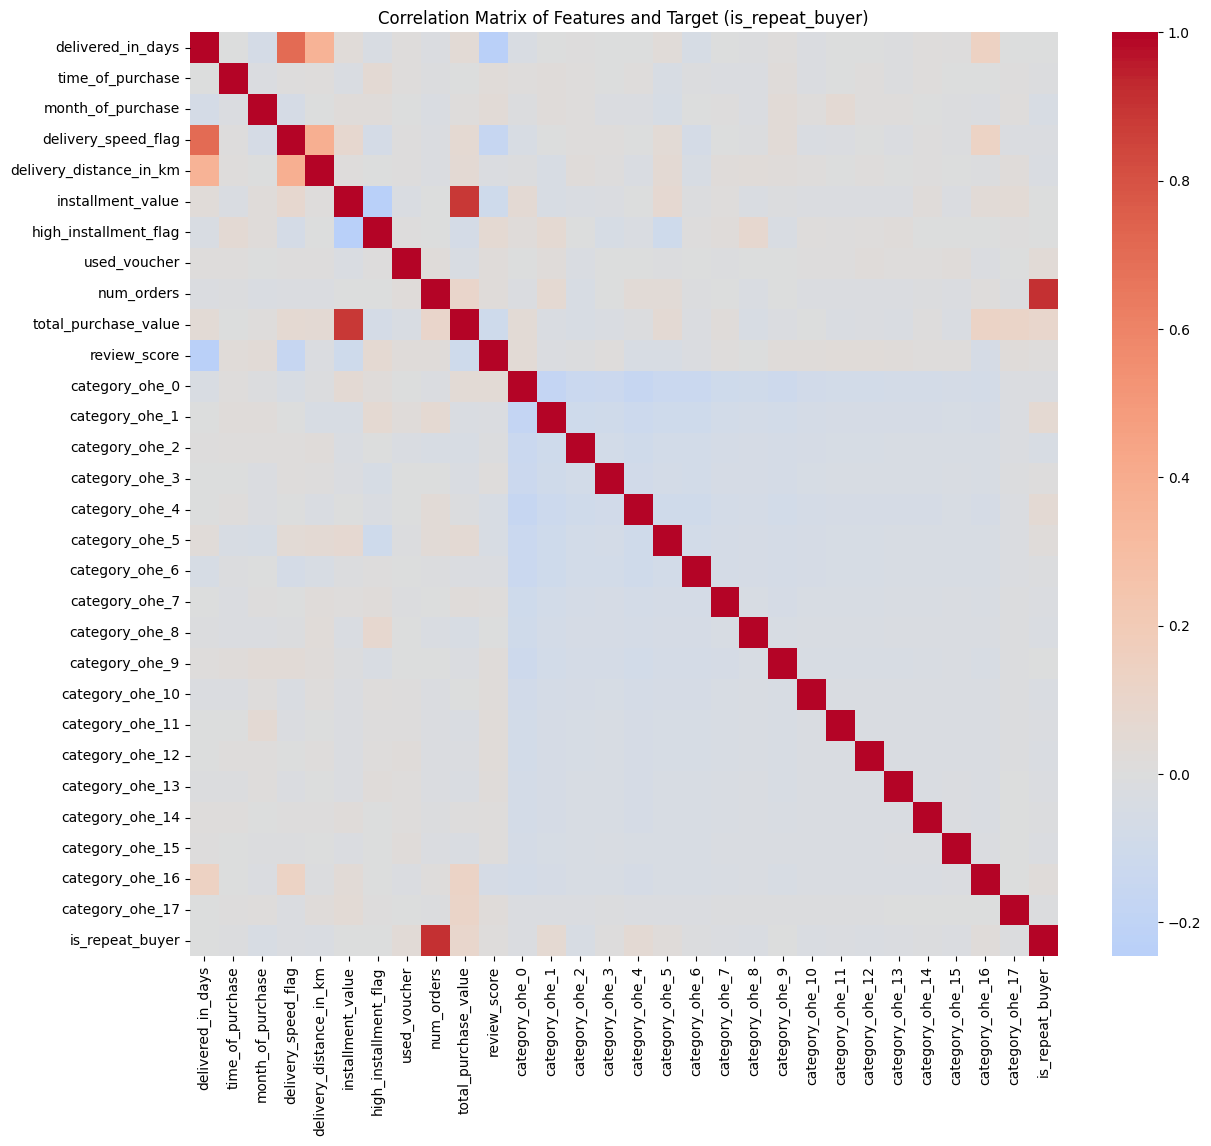

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Convert feature vector to array columns (if not done yet)
df_features = assembled_df.withColumn("features_array", vector_to_array("features"))

# Select feature array and label
df_features = df_features.select("features_array", "is_repeat_buyer")

# Convert to Pandas
pandas_df = df_features.toPandas()

# Expand feature array to separate columns
features_expanded = pd.DataFrame(pandas_df["features_array"].tolist(), columns=all_features)

# Combine with label
pandas_full = pd.concat([features_expanded, pandas_df["is_repeat_buyer"]], axis=1)

# Compute correlation matrix
corr_matrix = pandas_full.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features and Target (is_repeat_buyer)")
plt.show()
